In [5]:
from anthropic import Anthropic
import itertools
import os

In [7]:
client = Anthropic(
    api_key=os.getenv("ANTHROPIC_API_KEY")
)
model = "claude-3-haiku-20240307"
# model = "claude-3-5-sonnet-20240620"

In [8]:
prompts, responses, fnames = [], [], []

In [9]:
[{"role": "user" if i==0 else "assistant", "content": val if val else ""} for pair in itertools.zip_longest(prompts, responses) for i, val in enumerate(pair)]
def compile_msg_history(prompts: list[str], responses: list[str]):
    """ Transforms lists of messages into a message history usable by the Anthropic API as the `messages` parameter. """
    return [{"role": "user" if i==0 else "assistant", "content": val if val else ""} for pair in itertools.zip_longest(prompts, responses) for i, val in enumerate(pair)]

## Data + Plot: Dummy

In [10]:
fnames.append('data/GDP_growth.csv')
prompts.append("Generate data in CSV format. Output only the data without any other text. The data has 3 columns labeled 'China', 'USA', and 'Russia'. The values in each column are increasing, but 'China' is increasing most quickly.")
gen_data = client.messages.create(
    model=model,
    max_tokens=1000,
    messages=compile_msg_history(prompts, responses)
)
responses.append(gen_data.content[0].text)
print(responses[-1])

China,USA,Russia
10,5,3
20,8,5
30,10,7
40,12,9
50,14,11


In [11]:
# Write the content to a .csv file
with open(fnames[-1], "w") as f:
    f.write(responses[-1])

In [ ]:
fnames.append('plot.py')
prompts.append(f"Write a python function called `plot_GDP` which creates a line graph of the data you generated. You first need to load the data from the file {fnames[-2]}. The graph should appear appropriate for an academic paper. You may use either the matplotlib or seaborn libraries, but any library you use you must import at the start of the file, including pandas. Output only commented Python code without any ``` backticks surrounding it.")
gen_data = client.messages.create(
    model=model,
    max_tokens=1000,
    messages=compile_msg_history(prompts, responses)
)
responses.append(gen_data.content[0].text)
print(responses[-1])

import pandas as pd
import matplotlib.pyplot as plt

def plot_GDP(data_file):
    # Load the data from the file
    data = pd.read_csv(data_file)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data as line graphs
    data.plot(ax=ax, linewidth=2)

    # Set the title and axis labels
    ax.set_title('GDP Growth Over Time', fontsize=16)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('GDP', fontsize=14)

    # Set the legend properties
    ax.legend(loc='upper left', fontsize=12)

    # Set the grid lines
    ax.grid(linestyle='--', alpha=0.5)

    # Adjust the spacing between subplots
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)

    # Show the plot
    plt.show()


In [ ]:
# Write the content to a .py file
# with open(fnames[-1], "w") as f:
#     f.write(responses[-1])

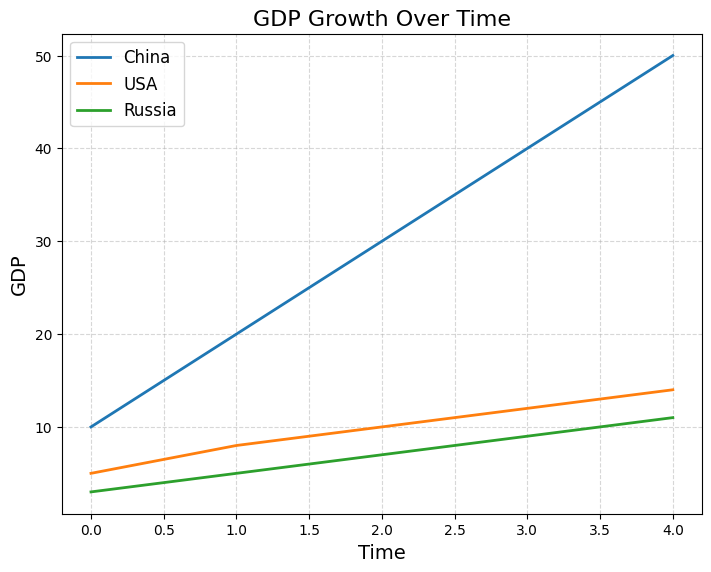

In [12]:
import plot
plot.plot_GDP('data/GDP_growth.csv')
# plot.plot_GDP(fnames[-2])